# Comparing Markowitz Portfolio and Order 0 Sig Trader

Context: we have a universe with $d$ stocks and we assume stationnary returns $R_t\sim N(\mu,C)$ where $\mu \in \mathbb{R}^d$ and $C\in M_d(\mathbb{R})$.

Under such assumptions, Markowitz showed that the optimal static portfolio (for the Sharpe ratio) is given by $w^* \propto C^{-1}\mu$ with $w^*\in \mathbb{R}^d$ the optimal weights to set on each stock (proportional because exact value depends on the variance threshold we set).

Given that a Sig Trader of depth 0 simply takes a static position $\ell_m \in \mathbb{R}$ for each asset $1\leq m \leq d$, we expect that upon fitting the functionals on data generated according to the random process $R_t \sim N(\mu,C)$, we should have that $\ell \propto w^*$ (provided we fit enough data).

In order to check that this hypothesis is correct, we will propose

1) arbitrary gaussian return process $R_t\sim N(\mu,C)$ using custom parameters $\mu$ and $C$

2) generate synthetic samples from this process

3) fit the depth-0 Sig Trader on these samples

4) compare the obtained functionals $\ell = (\ell_m)_{1\leq m \leq d}$ with the optimal weights $w^*=C^{-1}\mu$, hoping to find a match

### 0. Import librairies

In [1]:
import trading_strategy
import torch
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

### 1. Define some utils

In [2]:
def unif_mu(n: int, mu_min: float, mu_max: float, delta_t: float) -> torch.Tensor:
    """Generate n uniformly distributed mu's between mu_min and mu_max"""
    mu_annual = (mu_max - mu_min) * torch.rand(n) + mu_min
    mu_freq = mu_annual * delta_t
    return mu_freq

def toeplitz_cov(n: int, sigma_min: float, sigma_max: float, delta_t: float) -> torch.Tensor:
    """Generate a toeplitz covariance matrix with n elements and sigma_min and sigma_max"""
    sigmas_annual = (sigma_max - sigma_min) * torch.rand(n) + sigma_min
    sigmas_freq = sigmas_annual * np.sqrt(delta_t)
    cov = torch.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
            rho = np.exp(-np.abs(i - j)/np.sqrt(n))
            cov[i,j] = rho * sigmas_freq[i] * sigmas_freq[j]
            cov[j,i] = cov[i,j]
    return cov

def generate_correlated_returns(n_points: int, mu: torch.Tensor, cov: torch.Tensor) -> torch.Tensor:
    """
    Generate n_vectors of correlated returns with mean mu and covariance cov
    """
    return torch.distributions.MultivariateNormal(mu, cov).sample((n_points,))


def generate_batch_correlated_returns(batch_size: int, n_vectors: int, mu: torch.Tensor, cov: torch.Tensor) -> torch.Tensor:
    """
    Generate batch_size batch of n_vectors of correlated returns with mean mu and covariance cov
    """
    return torch.distributions.MultivariateNormal(mu, cov).sample((batch_size, n_vectors))


def rebuild_prices(returns: torch.Tensor, initial_prices: torch.tensor) -> torch.Tensor:
    """
    Rebuild prices from returns
    """
    n_points, n_assets = returns.shape
    prices = torch.zeros((n_points + 1, n_assets))
    prices[0] = initial_prices
    for i in range(returns.shape[0]):
        prices[i+1] = prices[i] * (1 + returns[i])
    return prices

### 2. Generate synthetic data

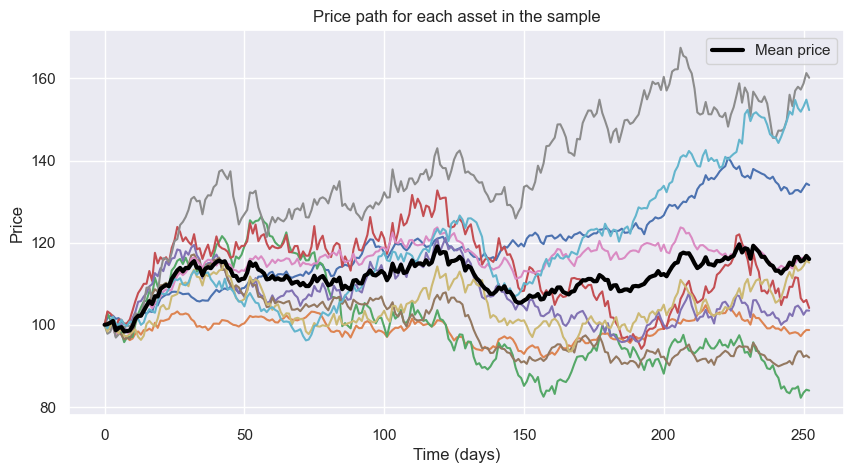

In [3]:
n_assets = 10 # number of assets we're trading
freq = 252 # daily data (so daily returns)
delta_t = 1/freq # time between two points in the time series
n_years = 1 # 1 year of data
n_points = int(n_years/delta_t) # number of points in the time series
initial_prices = 100 * torch.ones(n_assets) # initial prices (all assets start at 100 so that the graph looks nice)

# create the mu and cov
mu_min, mu_max = 0.05, 0.3 # annual return
mu = unif_mu(n_assets, mu_min, mu_max, delta_t) # hourly return
sigma_min, sigma_max = 0.1, 0.3 # annual volatility
cov = toeplitz_cov(n_assets, sigma_min, sigma_max, delta_t) # hourly covariance

batch_size = 1000 # number of samples in the batch (the more the better for the Sig Trader to learn)
info_data = torch.zeros((batch_size, n_points + 1, 0)) # no info data
batch_returns = generate_batch_correlated_returns(batch_size, n_points, mu, cov) # generate batch of returns
# rebuild prices from returns
batch_prices = torch.zeros((batch_size, n_points + 1, n_assets))
for i in range(batch_size):
    batch_prices[i] = rebuild_prices(batch_returns[i], initial_prices)

# plot the prices of an arbitrary sample of the batch
sample_index = 0 # index of the sample we want to plot
sample_returns = batch_returns[sample_index] # returns of the sample
sample_prices = batch_prices[sample_index] # prices of the sample
mean_price = torch.mean(sample_prices, dim=1) # mean price of the batch
plt.figure(figsize=(10,5))
plt.plot(sample_prices)
plt.plot(mean_price, color="black", linewidth=3, label="Mean price")
plt.legend()
plt.title("Price path for each asset in the sample")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.show()

### 3. Fit Markowitz Portfolio (easy since we perfectly know the underlying process)

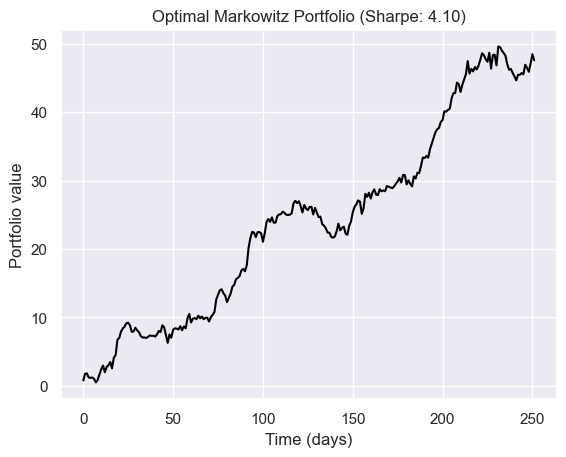

In [4]:
w_star= torch.inverse(cov) @ mu # optimal weights
w_star /= torch.sum(w_star) # normalize weights

ret = batch_returns[sample_index]
X = batch_prices[sample_index]
f = info_data[sample_index] # info data of the sample

# Markowitz portfolio
markowitz_return = torch.zeros(n_points)
markowitz_pnl = torch.zeros(n_points)
markowitz_global_pnl = torch.zeros(n_points)
for i in range(n_points):
    markowitz_return[i] = w_star @ ret[i, :]
    markowitz_pnl[i] = w_star @ (X[i, :] * ret[i, :])

markowitz_portfolio_value = torch.cumsum(markowitz_pnl, dim=0)
markowitz_mean_daily_return = torch.mean(markowitz_return)
markowitz_std_daily_return = torch.std(markowitz_return)
markowitz_sharpe_ratio = markowitz_mean_daily_return / markowitz_std_daily_return * np.sqrt(freq)

# let's plot the portfolio value over time
plt.plot(markowitz_portfolio_value, color='black')
plt.xlabel('Time (days)')
plt.ylabel('Portfolio value')
plt.title(f'Optimal Markowitz Portfolio (Sharpe: {markowitz_sharpe_ratio:.2f})')
plt.show()

### 4. Fit Order 0 Sig Trader (easy since depth=0)

In [5]:
# Sig Trader parameters
depth = 0
delta = 1 # variance criterion, not very important (simply rescale the positions xi)
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(batch_prices, info_data)
ts.print_functionals()

mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

L_1
Level 0:
tensor([0.0599])
L_2
Level 0:
tensor([0.0146])
L_3
Level 0:
tensor([-0.0103])
L_4
Level 0:
tensor([-0.0011])
L_5
Level 0:
tensor([0.0170])
L_6
Level 0:
tensor([-0.0256])
L_7
Level 0:
tensor([0.0132])
L_8
Level 0:
tensor([0.0045])
L_9
Level 0:
tensor([-0.0100])
L_10
Level 0:
tensor([0.0195])


### 5. Compare Markowitz and Order 0 Sig Trader weights

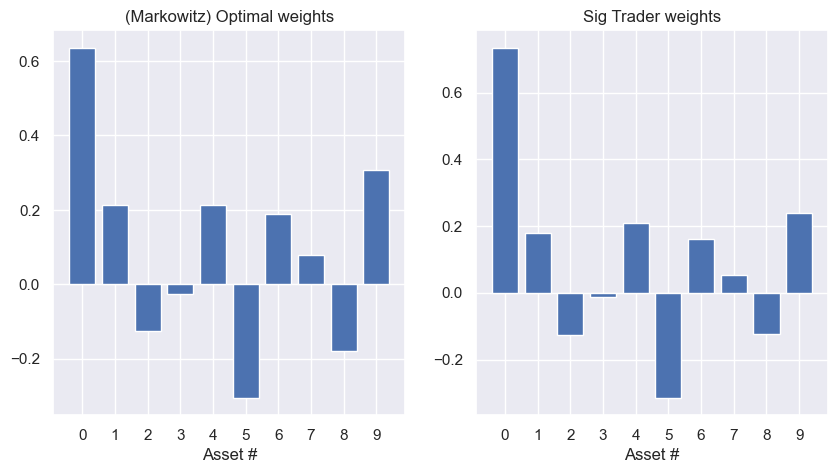

In [6]:
w_sig = torch.tensor([ts.functionals[i][0] for i in range(n_assets)])
w_sig = w_sig / torch.sum(w_sig) # normalize weights

# bar plot of w and w_sig
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].bar(range(n_assets), w_star)
axs[0].set_title('(Markowitz) Optimal weights')
axs[0].set_xlabel('Asset #')
axs[0].set_xticks(range(n_assets))
axs[1].bar(range(n_assets), w_sig)
axs[1].set_title('Sig Trader weights')
axs[1].set_xlabel('Asset #')
axs[1].set_xticks(range(n_assets))
plt.show()

As expected, the weights are very close. In other words, the Order 0 Sig Trader successfully learned Markowitz' optimal portfolio by observing the dynamics of the price process during the training phase.

We can compare the performance of the Markowitz vs. Sig Trader portfolio but since the weights are very close, they'll be very close as well.

### 6. Compare Markowitz and Order 0 Sig Trader performance

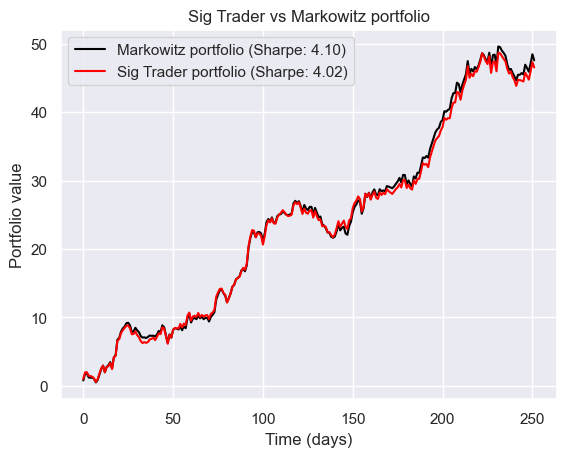

In [7]:
# Sig Trader portfolio
sig_trader_return = torch.zeros(n_points)
sig_trader_pnl = torch.zeros(n_points)
sig_trader_global_pnl = torch.zeros(n_points)
for i in range(n_points):
    sig_trader_return[i] = w_sig @ ret[i, :]
    sig_trader_pnl[i] = w_sig @ (X[i, :] * ret[i, :])

sig_trader_portfolio_value = torch.cumsum(sig_trader_pnl, dim=0)
sig_trader_mean_daily_return = torch.mean(sig_trader_return)
sig_trader_std_daily_return = torch.std(sig_trader_return)
sig_trader_sharpe_ratio = sig_trader_mean_daily_return / sig_trader_std_daily_return * np.sqrt(freq)

plt.figure()
plt.plot(markowitz_portfolio_value, color='black', label=f'Markowitz portfolio (Sharpe: {markowitz_sharpe_ratio:.2f})')
plt.plot(sig_trader_portfolio_value, color='red', label=f'Sig Trader portfolio (Sharpe: {sig_trader_sharpe_ratio:.2f})')
plt.xlabel('Time (days)')
plt.ylabel('Portfolio value')
plt.title('Sig Trader vs Markowitz portfolio')
plt.legend()
plt.show()